<a href="https://colab.research.google.com/github/yatta03/112-2PL/blob/main/hw4/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
!pip install pygsheets
!pip install transformers

In [74]:
import pandas as pd
import pygsheets
from transformers import pipeline
import re

In [75]:
# load data from google sheet
gc = pygsheets.authorize(service_file='./pl-421203-a74b8641e6bc.json')
sheetUrl = "https://docs.google.com/spreadsheets/d/1WdlcEpxjWRB0Xz9RsRALppZYU6_sVQyTgkTX4xeMsEA/"
sh = gc.open_by_url(sheetUrl)

In [76]:
ws = sh.worksheet_by_title("competitions")
compsData = ws.get_as_df()
compsData.head()

title totalPrize highiestPrize      dueTime  \
0                        2024 臺灣文學獎徵獎    3700000       1000000  投稿中：還有 2 個月   
1  Taiwan YOU & I 綠能大未來 臺灣再生能源短影音創作競賽     295000         50000  投稿中：還有 3 個月   
2        2024GenAI Stars生成式AI百工百業應用選拔    7000000       1500000  投稿中：還有 2 個月   
3                     E.WEDDING 女神製造營                           投稿中：還有 5 個月   
4                           2024集點子大賽      81000         10000   投稿中：還有 6 天   

                                                link  \
0  https://bhuntr.com/tw/competitions/2imncb1q228...   
1  https://bhuntr.com/tw/competitions/renewableenrgy   
2  https://bhuntr.com/tw/competitions/3th7d58bc38...   
3  https://bhuntr.com/tw/competitions/jul7diyz0o9...   
4  https://bhuntr.com/tw/competitions/6autnbu1g2i...   

                                         description  
0  壹、活動簡介為了向當年度優秀文學作品致敬，同時激發各類原創書寫，以彰顯臺灣價值、在地特色，進...  
1  Taiwan YOU & I  綠能大未來臺灣再生能源短影音創作競賽競賽辦法為呼應全球淨零趨...  
2  競賽宗旨AI技術為人類世界帶來翻天覆地的變革，生成式AI更從去年起為產業帶來新一輪破壞式創新...  
3  E.WEDDING 女神製造營冬季官方代言人徵選活動初衷 About Event：【E.WE...  
4  前言信義公益基金會致力於銀髮族的關懷與扶持，創會至今辦理許多高齡服務計畫；「集點子大賽」是一...

In [79]:
# load pretrained model, use pipeline directly
summarizer = pipeline("summarization", model="twwch/mt5-base-summary")

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


### this part is used to generate text for testing summarizer
raw data vs. data without english words and digits

In [77]:
compsData["description"][8][:100]

'一、比賽宗旨在人工智慧席捲全球的浪潮下，今年 GIGABYTE 攜手 VS AI 街頭對戰，以 Midjourney 為對戰工具，打破既有藝術表達方式的限制，期望尋找新世代的人類咒術師即 AI 人工智'

In [78]:
filterDes = []
des = compsData["description"]

for inx, d in enumerate(des):
  filterDes.append(re.sub(r'[\s\da-zA-Z]', '', d))
  filterDes[inx] = re.sub(r'[\s]', '', filterDes[inx]) # remove white space

filterDes[8][:100]

'一、比賽宗旨在人工智慧席捲全球的浪潮下，今年攜手街頭對戰，以為對戰工具，打破既有藝術表達方式的限制，期望尋找新世代的人類咒術師即人工智慧藝術創作者。【｜街頭對戰】包含線上競賽，及八強選手面對面實體對戰'

raw data won  
so I will use it in code below

In [85]:
import jieba
import jieba.analyse

In [88]:
# summarize with a predefined summarizer
# then use jieba to find keywords(top topK)
def extractKeywords(inputText):
  out = summarizer(inputText, max_length=64)
  keywords = jieba.analyse.extract_tags(out[0]['summary_text'], topK=10)
  # print("end")
  return keywords

In [89]:
# for lighter computation, use only 15 data entries
smallData = compsData[:15][:]
smallData["keywords"] = smallData['description'].apply(extractKeywords)

In [90]:
smallData.head()

title totalPrize highiestPrize      dueTime  \
0                        2024 臺灣文學獎徵獎    3700000       1000000  投稿中：還有 2 個月   
1  Taiwan YOU & I 綠能大未來 臺灣再生能源短影音創作競賽     295000         50000  投稿中：還有 3 個月   
2        2024GenAI Stars生成式AI百工百業應用選拔    7000000       1500000  投稿中：還有 2 個月   
3                     E.WEDDING 女神製造營                           投稿中：還有 5 個月   
4                           2024集點子大賽      81000         10000   投稿中：還有 6 天   

                                                link  \
0  https://bhuntr.com/tw/competitions/2imncb1q228...   
1  https://bhuntr.com/tw/competitions/renewableenrgy   
2  https://bhuntr.com/tw/competitions/3th7d58bc38...   
3  https://bhuntr.com/tw/competitions/jul7diyz0o9...   
4  https://bhuntr.com/tw/competitions/6autnbu1g2i...   

                                         description  \
0  壹、活動簡介為了向當年度優秀文學作品致敬，同時激發各類原創書寫，以彰顯臺灣價值、在地特色，進...   
1  Taiwan YOU & I  綠能大未來臺灣再生能源短影音創作競賽競賽辦法為呼應全球淨零趨...   
2  競賽宗旨AI技術為人類世界帶來翻天覆地的變革，生成式AI更從去年起為產業帶來新一輪破壞式創新...   
3  E.WEDDING 女神製造營冬季官方代言人徵選活動初衷 About Event：【E.WE...   
4  前言信義公益基金會致力於銀髮族的關懷與扶持，創會至今辦理許多高齡服務計畫；「集點子大賽」是一...   

                                            keywords  
0   [活动, 2023, 灣文學奖, 灣的, 創作獎, 金典, 当年度, 致敬, 彰显, 文学作品]  
1         [报名, 17, 2024, 11, 要求, 日至, 时间, 评分, 涉及, 以下]  
2  [GenAI, 輔導, 选拔, 生成式, Stars, AI, 創業組, 关鍵, 百业, 参赛者]  
3  [女神, 活动, 时程, WEDDING, 徵选, 实踐, 內心, 回憶, Rundown,...  
4        [高齡, 点子, 公益, 基金会, 活动, 信義, 2024, 大賽, 鼓勵, 信义]

In [91]:
import matplotlib.pyplot as plt
import networkx as nx

In [92]:
def addNode(node, G, nType):
  G.add_node(node, type=nType)
  return

def addNodeList(nList, G, nType):
  try:
    nList.apply(addNode, args=(G,nType))
  except:
    for n in nList:
      addNode(n, G, nType)
  return

def addEdge(node, G, targetList):
  for t in targetList:
    G.add_edge(node, t)
  return

def addEdgeList(nList, G, tLists):
  for inx, n in enumerate(nList):
    addEdge(n, G, tLists[inx])
  return

In [94]:
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
import matplotlib as mpl
from matplotlib.font_manager import fontManager

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

--2024-04-25 15:15:56--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 74.125.23.113, 74.125.23.138, 74.125.23.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.23.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2024-04-25 15:15:57--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.8.132, 2404:6800:4008:c15::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.8.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M   108MB/s    in 0.2s    

2024-04-25 15:16:02 (10

In [105]:
G = nx.Graph()

smallData["title"].apply(addNode, args=(G, "title"))
smallData["keywords"].apply(addNodeList, args=(G, "tag"))
addEdgeList(smallData["title"], G, smallData["keywords"])

In [118]:
# add the tags from hw3
tws = sh.worksheet_by_title("tag_comps")
tag_comps = tws.get_as_df()
tag_comps.head()

tagName                    competitionTitle
0    影片比賽  Taiwan YOU & I 綠能大未來 臺灣再生能源短影音創作競賽
1    政府主辦  Taiwan YOU & I 綠能大未來 臺灣再生能源短影音創作競賽
2      短片  Taiwan YOU & I 綠能大未來 臺灣再生能源短影音創作競賽
3    學生競賽  Taiwan YOU & I 綠能大未來 臺灣再生能源短影音創作競賽
4  社會人士競賽  Taiwan YOU & I 綠能大未來 臺灣再生能源短影音創作競賽

In [129]:
def addFromRelation(title, relation, G, tType):
  tList = relation[relation["competitionTitle"]==title]["tagName"]
  tList.apply(addNode, args=(G, tType))
  addEdge(title, G, tList)
  return

smallData["title"].apply(addFromRelation, args=(tag_comps, G, "tags2"))

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
Name: title, dtype: object

(-1.0699737486786405, 1.196694338109735, -1.099180432801227, 1.126456725278226)

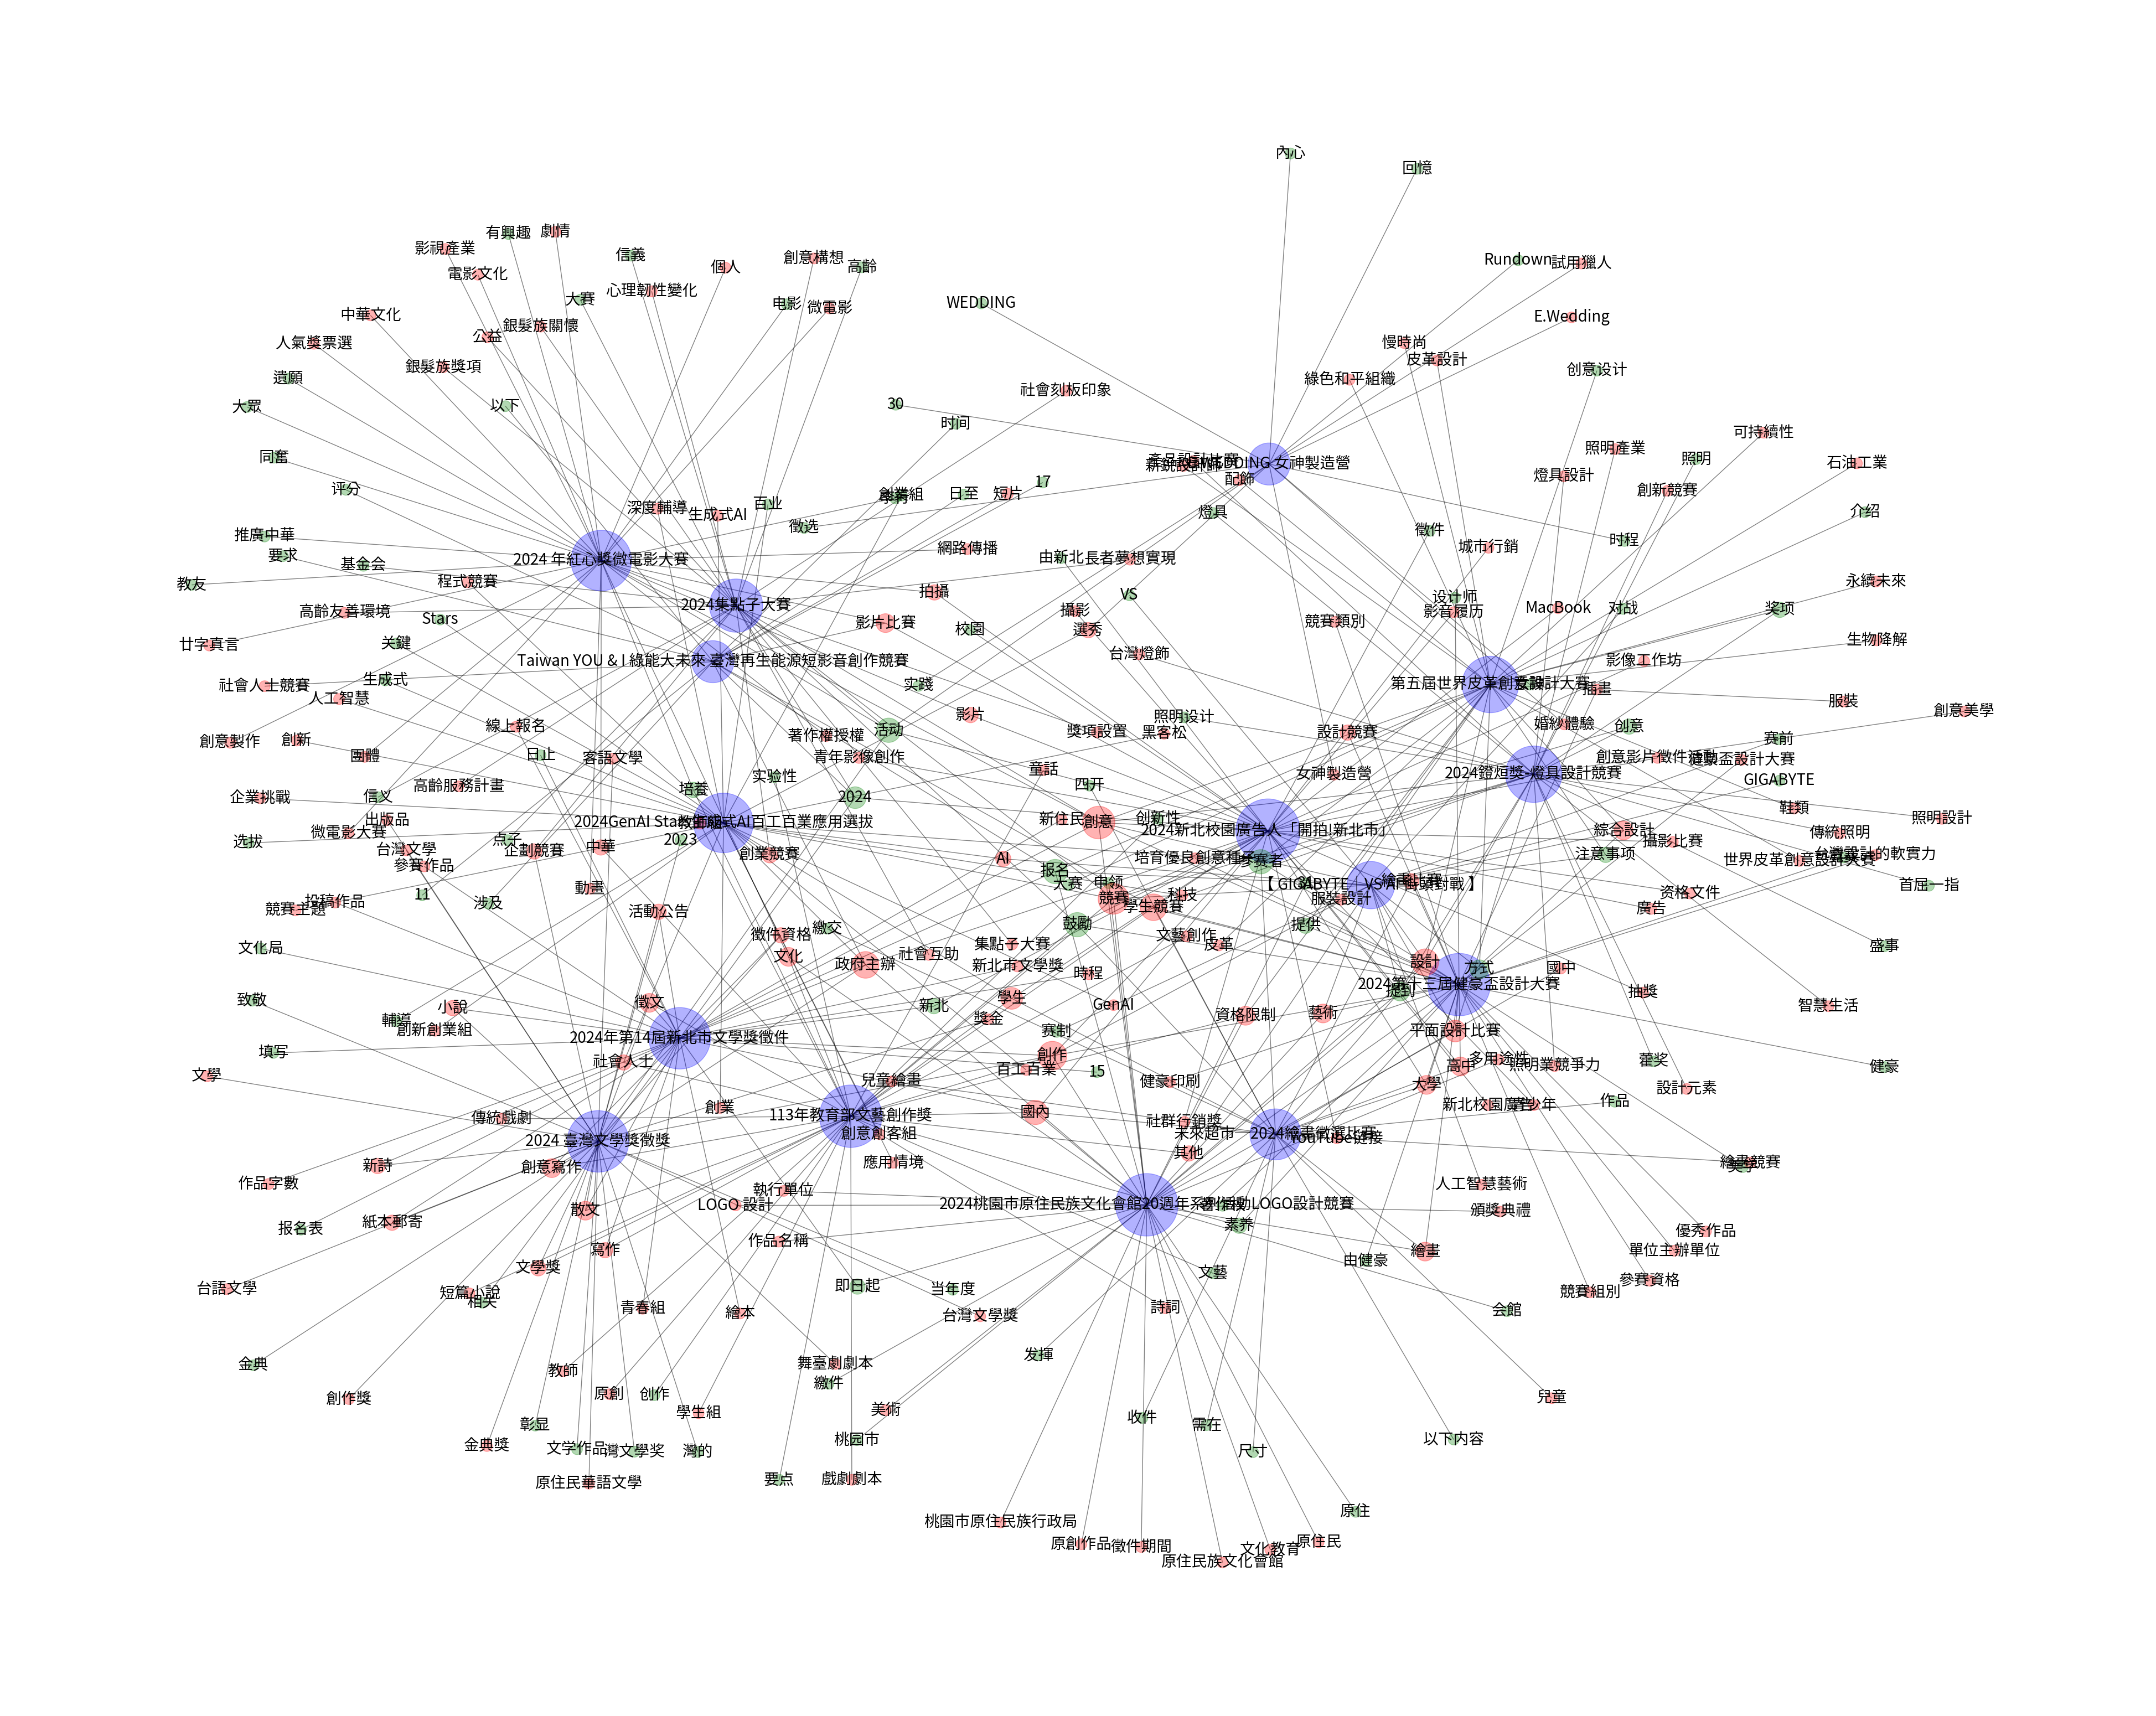

In [138]:
import matplotlib.colors as mcolors

colors_with_alpha = [
    (lambda c: mcolors.to_rgba(c, alpha=0.3))("blue")
    if G.nodes[node]['type'] == 'title'
    else
    (lambda c: mcolors.to_rgba(c, alpha=0.3))("green")
    if G.nodes[node]['type'] == 'tag'
    else
    (lambda c: mcolors.to_rgba(c, alpha=0.3))("red")
    for node in G.nodes()
]
node_sizes = [200 * G.degree(node) for node in G.nodes()]

pos = nx.spring_layout(G, k=0.5, iterations=100)

plt.figure(figsize=(50, 40))
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_nodes(G, pos, node_color=colors_with_alpha, node_size=node_sizes)
nx.draw_networkx_labels(G, pos, font_size=20, font_family='Taipei Sans TC Beta')
plt.axis('off')